# 1.0 An end-to-end classification problem (ETL)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [Kaggle](https://www.kaggle.com/datasets/samaxtech/lending-club-20072011-data).

Let's take the following steps:

1. Load Libraries
2. Fetch Data, including EDA
3. Pre-procesing
4. Data Segregation

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## 1.2 Install and load libraries

In [ ]:
!pip install pandas-profiling==3.1.0

In [ ]:
!pip install wandb

In [ ]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import tempfile
import os
import warnings

In [ ]:
%matplotlib inline
warnings.filterwarnings('ignore')

## 1.3 Exploratory Data Analysis (EDA)

### 1.3.1 Login wandb


In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 1.3.2 Download raw_data artifact from Wandb

In [ ]:
# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project="risk_credit", save_code=True)

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


In [ ]:
# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact("risk_credit/raw_data.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          42538 non-null  object 
 1   member_id                   42535 non-null  float64
 2   loan_amnt                   42535 non-null  float64
 3   funded_amnt                 42535 non-null  float64
 4   funded_amnt_inv             42535 non-null  float64
 5   term                        42535 non-null  object 
 6   int_rate                    42535 non-null  object 
 7   installment                 42535 non-null  float64
 8   grade                       42535 non-null  object 
 9   sub_grade                   42535 non-null  object 
 10  emp_title                   39909 non-null  object 
 11  emp_length                  41423 non-null  object 
 12  home_ownership              42535 non-null  object 
 13  annual_inc                  425

In [ ]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,4.253500e+04,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42535.000000,42506.000000,42506.000000,42506.000000,...,42535.000000,42535.000000,42535.000000,42390.0,42535.0,42506.000000,42390.0,42506.000000,41170.000000,42430.000000
mean,8.257026e+05,11089.722581,10821.585753,10139.830603,322.623063,6.913656e+04,13.373043,0.152449,1.081424,9.343951,...,99.760718,13.858267,2610.756511,0.0,1.0,0.000094,0.0,0.143039,0.045227,0.000024
std,2.795409e+05,7410.938391,7146.914675,7131.686446,208.927216,6.409635e+04,6.726315,0.512406,1.527455,4.496274,...,716.220266,159.360372,4385.636417,0.0,0.0,0.009700,0.0,29.359579,0.208737,0.004855
min,7.047300e+04,500.000000,500.000000,0.000000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,6.384795e+05,5200.000000,5000.000000,4950.000000,165.520000,4.000000e+04,8.200000,0.000000,0.000000,6.000000,...,0.000000,0.000000,211.460000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
50%,8.241780e+05,9700.000000,9600.000000,8500.000000,277.690000,5.900000e+04,13.470000,0.000000,1.000000,9.000000,...,0.000000,0.000000,526.150000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.033946e+06,15000.000000,15000.000000,14000.000000,428.180000,8.250000e+04,18.680000,0.000000,2.000000,12.000000,...,0.000000,0.000000,3165.450000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
max,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,13.000000,33.000000,47.000000,...,29623.350000,7002.190000,36115.200000,0.0,1.0,1.000000,0.0,6053.000000,2.000000,1.000000


### 1.3.3 Pandas Profilling

In [ ]:
ProfileReport(df, title="Pandas Profiling Report", explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.3.4 EDA Manually

In [ ]:
# There are duplicated rows
df.duplicated().sum()

0

In [ ]:
# Delete duplicated rows
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

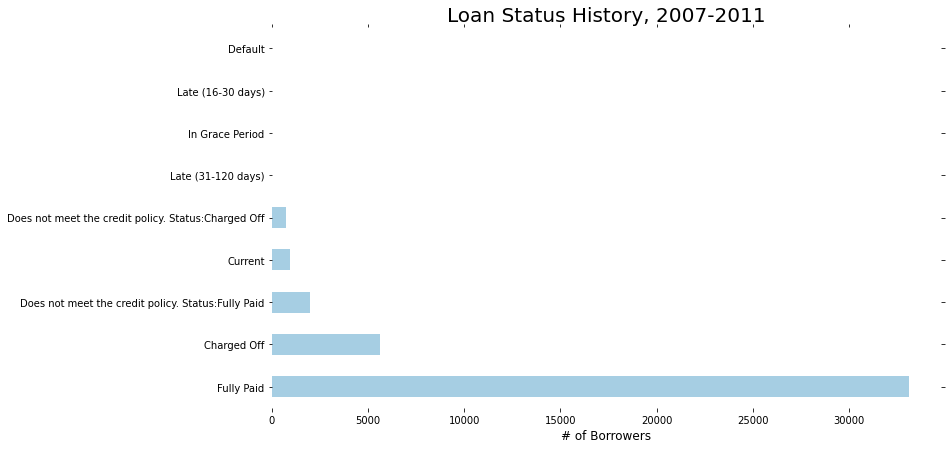

In [ ]:
freq_loan_status = df['loan_status'].value_counts() 

fig, ax = plt.subplots(figsize=(12,7))
freq_loan_status.plot(kind='barh',alpha=1, rot=0, colormap=plt.cm.Paired)

plt.title('Loan Status History, 2007-2011', size=20)
plt.xlabel('# of Borrowers', size=12)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(top="off", left="off", right="off", bottom='off')

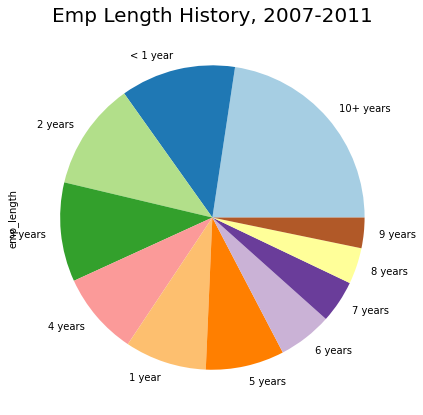

In [ ]:
freq_emp_length = df['emp_length'].value_counts() 

fig, ax = plt.subplots(figsize=(12,7))
freq_emp_length.plot(kind='pie', rot=0, colormap=plt.cm.Paired)

plt.title('Emp Length History, 2007-2011', size=20)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(top="off", left="off", right="off", bottom='off')

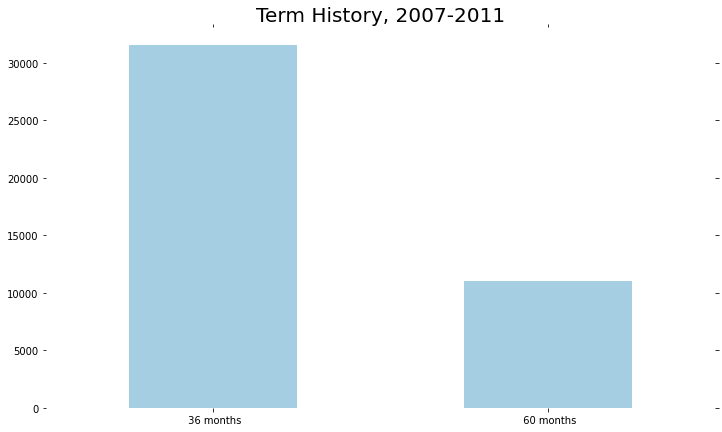

In [ ]:
freq_term = df['term'].value_counts() 

fig, ax = plt.subplots(figsize=(12,7))
freq_term.plot(kind='bar',alpha=1, rot=0, colormap=plt.cm.Paired)

plt.title('Term History, 2007-2011', size=20)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(top="off", left="off", right="off", bottom='off')

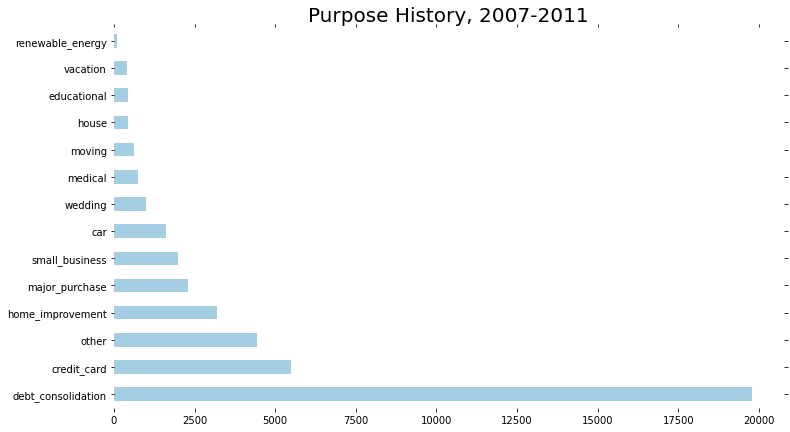

In [ ]:
freq_purpose = df['purpose'].value_counts() 

fig, ax = plt.subplots(figsize=(12,7))
freq_purpose.plot(kind='barh',alpha=1, rot=0, colormap=plt.cm.Paired)

plt.title('Purpose History, 2007-2011', size=20)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(top="off", left="off", right="off", bottom='off')

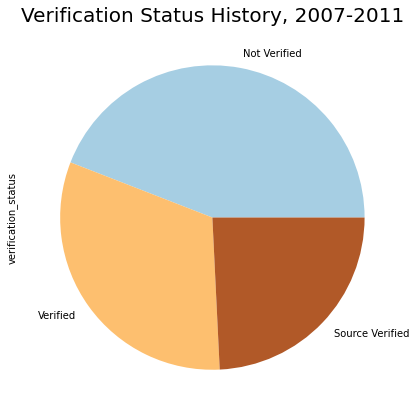

In [ ]:
freq_verification = df['verification_status'].value_counts() 

fig, ax = plt.subplots(figsize=(12,7))
freq_verification.plot(kind='pie', rot=0, colormap=plt.cm.Paired)

plt.title('Verification Status History, 2007-2011', size=20)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(top="off", left="off", right="off", bottom='off')

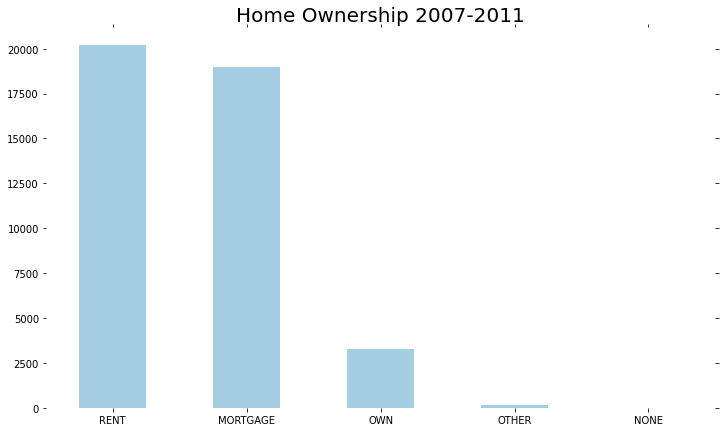

In [ ]:
freq_home_ownership = df['home_ownership'].value_counts() 

fig, ax = plt.subplots(figsize=(12,7))
freq_home_ownership.plot(kind='bar',alpha=1, rot=0, colormap=plt.cm.Paired)

plt.title('Home Ownership 2007-2011', size=20)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(top="off", left="off", right="off", bottom='off')

In [ ]:
df.isnull().sum()

id                               0
member_id                        3
loan_amnt                        3
funded_amnt                      3
funded_amnt_inv                  3
term                             3
int_rate                         3
installment                      3
grade                            3
sub_grade                        3
emp_title                     2629
emp_length                    1115
home_ownership                   3
annual_inc                       7
verification_status              3
issue_d                          3
loan_status                      3
pymnt_plan                       3
purpose                          3
title                           16
zip_code                         3
addr_state                       3
dti                              3
delinq_2yrs                     32
earliest_cr_line                32
inq_last_6mths                  32
open_acc                        32
pub_rec                         32
revol_bal           

In [ ]:
run.finish()